In [72]:
#!/usr/bin/env python3
import json
import numpy as np
import requests
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from manual_review_classifier.ClassifierPlots import create_reliability_diagram, create_roc_curve

###Create Tools for code
#create tool that can append files to a list
def append_file_to_list(file):
    list = []
    f = open(file, 'r')
    for line in f:
        line = line.strip('\n')
        line = line.split('\t')
        list.append(line)
    return list


In [73]:
#open error file for deep learning
error_data = append_file_to_list('../data/clinical_analysis_data/errors_dl.tsv')
error_pd = pd.read_csv('../data/clinical_analysis_data/errors_dl.tsv', sep='\t')
training_data = pd.read_pickle('../data/training_data.pkl')
full_data = pd.read_pickle('../data/full_sample_df.pkl')

In [74]:
#Make sure that the DoCM Variants and CIViC Variants overlap

CIViC_FN = append_file_to_list("../data/clinical_analysis_data/CIViC_variants_DL_FN.txt")
DoCM_FN = append_file_to_list("../data/clinical_analysis_data/DoCM_variants_DL_FN.txt")

overlap_FN = 0

for item in DoCM_FN:
    code = item[0:5]
    for thing in CIViC_FN:
        code2 = item[0:5]
        if code == code2:
            overlap_FN += 1
            break
            
CIViC_FP = append_file_to_list("../data/clinical_analysis_data/CIViC_variants_DL_FP.txt")
DoCM_FP = append_file_to_list("../data/clinical_analysis_data/DoCM_variants_DL_FP.txt")

overlap_FP = 0

for item in DoCM_FP:
    code = item[0:5]
    for thing in CIViC_FP:
        code2 = item[0:5]
        if code == code2:
            overlap_FP += 1
            break

In [5]:
FN_no_clinical = {}
FN_clinical = {}
for number,thing in enumerate(error_data):
    if thing[2] == 'False Negative':
        code1 = thing[7:12]
        prob1 = thing[5][0:5]
        for item in CIViC_FN[1:]:
            code2 = item[0:5]
            prob2 = item[7][0:5]
            if code1 == code2 and prob1 == prob2:
                FN_clinical[number] = thing
for number,thing in enumerate(error_data):
    if thing[2] == 'False Negative' and number not in FN_clinical:
        FN_no_clinical[number] = thing
                             
FP_no_clinical = {}
FP_clinical = {}
for number,thing in enumerate(error_data):
    if thing[2] == 'False Positive':
        code1 = thing[7:12]
        prob1 = thing[5][0:5]
        for item in CIViC_FP[1:]:
            code2 = item[0:5]
            prob2 = item[7][0:5]
            if code1 == code2 and prob1 == prob2:
                FP_clinical[number] = thing
for number,thing in enumerate(error_data):
    if thing[2] == 'False Positive' and number not in FP_clinical:
        FP_no_clinical[number] = thing

In [6]:
#Pull the non-Clinical Flase Positives and take random 30

FP_no_clinical_IGV = []
for item in range(45):
    number = np.random.choice((list(FP_no_clinical.keys())))
    FP_no_clinical_IGV.append(FP_no_clinical[number])


In [7]:
#Pull the non-Clinical Flase Negatives and take random 30

FN_no_clinical_IGV = []
for item in range(45):
    number = np.random.choice((list(FN_no_clinical.keys())))
    FN_no_clinical_IGV.append(FN_no_clinical[number])

In [8]:
#Pull the Clinical False Negatives and False Positives
FP_clinical_IGV = []
for k,v in FP_clinical.items():
    FP_clinical_IGV.append(v)
    
FN_clinical_IGV = []
for k,v in FN_clinical.items():
    FN_clinical_IGV.append(v)

In [81]:
#print all clinical to lists
np.savetxt("../data/manual_rereview/clin_FP.csv", FP_clinical_IGV, delimiter=",", fmt='%s')
np.savetxt("../data/manual_rereview/clin_FN.csv", FN_clinical_IGV, delimiter=",", fmt='%s')

In [13]:
#print all non_clinical to lists
np.savetxt("../data/non_clin_FP.csv", FP_no_clinical_IGV, delimiter=",", fmt='%s')
np.savetxt("../data/non_clin_FN.csv", FN_no_clinical_IGV, delimiter=",", fmt='%s')

In [75]:
MRR = append_file_to_list("/Users/ebarnell/manual_review_classifier/data/manual_rereview/manual_rereview.txt")

In [76]:
calls = [16, 17, 18, 19, 20, 21, 22]
MRR_new = []
MR_count = 0
classifier_count = 0
new_consensus = 0
no_consensus = 0
for item in MRR[1:]:
    F = 0
    S = 0
    A = 0
    for k in calls:
        if item[k] == 'S':
            S += 1
        if item[k] == 'F':
            F += 1
        if item[k] == 'A':
            A += 1
    if F > S and F > A:
        consensus = 'F'
    elif S > F and S > A:
        consensus = 'S'
    elif A > F and A > S:
        consensus = 'A'
    else:
        consensus = 'none'
        no_consensus += 1
        agree = 'none'
    if item[0] == consensus:
        agree = "MR"
        MR_count += 1
    elif item[1] == consensus:
        agree = "Classifier"
        classifier_count += 1
    elif item[0] != consensus and item[1] != consensus:
        agree = 'new'
        new_consensus += 1
    MRR_new.append([item[0], item[1], item[2], item[3], item[25], consensus, agree])
    

In [89]:
total = len(MRR_new)
print('Total Variants: ',total)
print('MR-Variants: ',MR_count)
print('Classifier-Variants: ',classifier_count)
print('Change-Variants: ',new_consensus)
print('No Consensus: ',no_consensus)

Total Variants:  179
MR-Variants:  58
Classifier-Variants:  57
Change-Variants:  64
No Consensus:  13


['MR_Call', 'Classifier_Call', 'Type', 'Clin vs Non', 'Ambiguous', 'Fail', 'Somatic', 'Sample_Name', 'Chr', 'Start', 'Stop', 'Ref', 'Var', 'Disease', 'Order', 'Number', 'Reviewer 1', 'Reviewer 2', 'Reviewer 3', 'Reviewer 4', 'Reviewer 5', 'Reviewer 6', 'Reviewer 7', 'Fail', 'Somatic', 'Access to Relapse']


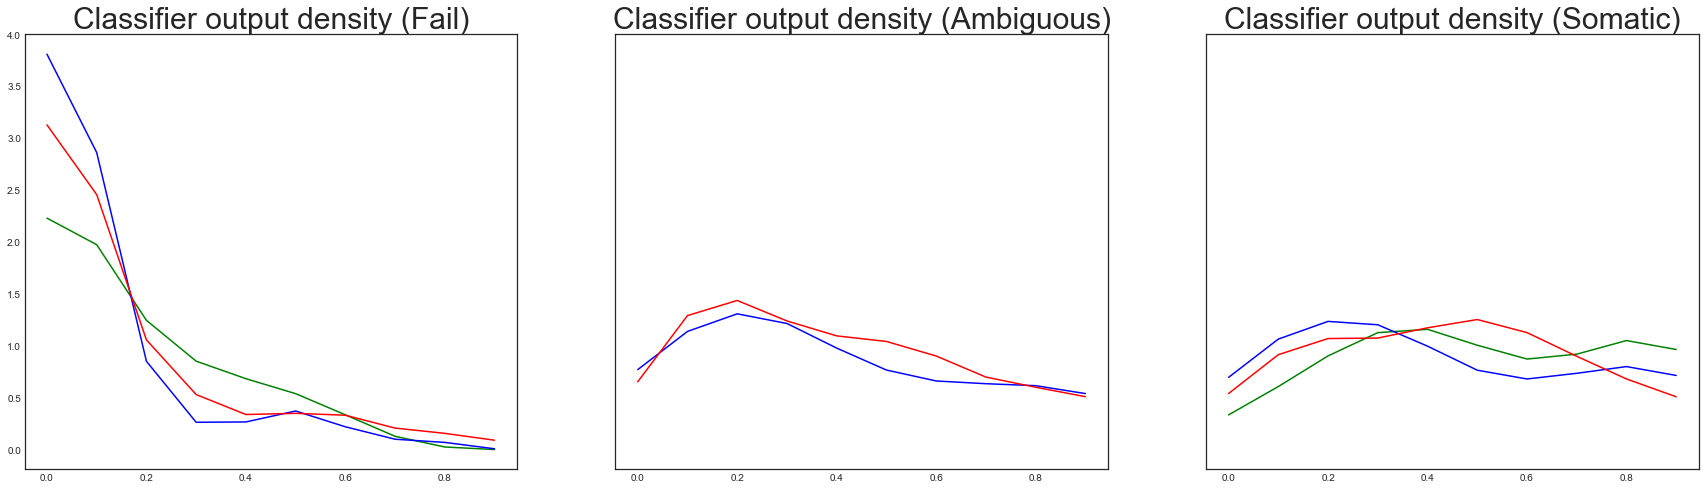

In [90]:
print(MRR[0])

MRR_agreement_high_F = []
MRR_agreement_mid_F = []
MRR_agreement_low_F = []

MRR_agreement_high_A = []
MRR_agreement_mid_A = []
MRR_agreement_low_A = []

MRR_agreement_high_S = []
MRR_agreement_mid_S = []
MRR_agreement_low_S = []

for item in MRR[1:]:
    amb_prob = item[4]
    fail_prob = item[5]
    som_prob = item[6]
    F = 0
    S = 0
    A = 0
    for k in calls:
        if item[k] == 'S':
            S += 1
        if item[k] == 'F':
            F += 1
        if item[k] == 'A':
            A += 1
    
    if float(F) == 7 or float(F) == 6:
        MRR_agreement_high_F.append(float(fail_prob))
    if float(F) == 5 or float(F) == 4 or float(F) == 3:
        MRR_agreement_mid_F.append(float(fail_prob))
    if float(F) == 2 or float(F) == 1 or float(F) == 0:
        MRR_agreement_low_F.append(float(fail_prob))
        
    if float(A) == 7 or float(A) == 6:
        MRR_agreement_high_A.append(float(amb_prob))
    if float(A) == 5 or float(A) == 4 or float(A) == 3:
        MRR_agreement_mid_A.append(float(amb_prob))
    if float(A) == 2 or float(A) == 1 or float(A) == 0:
        MRR_agreement_low_A.append(float(amb_prob))
        
    if float(S) == 7 or float(S) == 6:
        MRR_agreement_high_S.append(float(som_prob))
    if float(S) == 5 or float(S) == 4 or float(S) == 3:
        MRR_agreement_mid_S.append(float(som_prob))
    if float(S) == 2 or float(S) == 1 or float(S) == 0:
        MRR_agreement_low_S.append(float(som_prob))
        
from scipy import stats

density_high_F = stats.kde.gaussian_kde(MRR_agreement_high_F)
density_mid_F = stats.kde.gaussian_kde(MRR_agreement_mid_F)
density_low_F = stats.kde.gaussian_kde(MRR_agreement_low_F)

# density_high_A = stats.kde.gaussian_kde(MRR_agreement_high_A)
density_mid_A = stats.kde.gaussian_kde(MRR_agreement_mid_A)
density_low_A = stats.kde.gaussian_kde(MRR_agreement_low_A)

density_high_S = stats.kde.gaussian_kde(MRR_agreement_high_S)
density_mid_S = stats.kde.gaussian_kde(MRR_agreement_mid_S)
density_low_S = stats.kde.gaussian_kde(MRR_agreement_low_S)


x = np.arange(0., 1, .1)
f, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(30, 8))
ax1.set_title('Classifier output density (Fail)', size=30)
ax1.plot(x, density_high_F(x), color='green')
ax1.plot(x, density_mid_F(x), color='blue')
ax1.plot(x, density_low_F(x), color='red')

ax2.set_title('Classifier output density (Ambiguous)', size=30)
# ax2.plot(x, density_high_A(x), color='green')
ax2.plot(x, density_mid_A(x), color='blue')
ax2.plot(x, density_low_A(x), color='red')

ax3.set_title('Classifier output density (Somatic)', size=30)
ax3.plot(x, density_high_S(x), color='green')
ax3.plot(x, density_mid_S(x), color='blue')
ax3.plot(x, density_low_S(x), color='red')
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=True)

plt.show()
# plt.savefig('/Users/ebarnell/Desktop/density.png')   # save the figure to file



In [16]:
reviews = [[('../data/reviewer_comparison/H_KA-115225/H_KA-115225_reviewed.bed.formated', False, 'H_KA-115225'), ('../data/reviewer_comparison/H_KA-115225/H_KA-115225_reviewed.lmt.bed', True, 'H_KA-115225'), ('../data/reviewer_comparison/H_KA-115225/H_KA-115225_reviewed_Erica.txt', True, 'H_KA-115225')],
           [('../data/reviewer_comparison/H_ML-08-0075-202-1121768/H_ML-08-0075-202-1121768_reviewed.bed.formated', False, 'H_ML-08-0075-202'), ('../data/reviewer_comparison/H_ML-08-0075-202-1121768/H_ML-08-0075-202-1121768_reviewed.lmt.bed', True, 'H_ML-08-0075-202'), ('../data/reviewer_comparison/H_ML-08-0075-202-1121768/H_ML-08-0075-202-1121768_Erica.txt', True, 'H_ML-08-0075-202') ],
           [('../data/reviewer_comparison/H_ND-006G-C117D/H_ND-006G-C117D_reviewed.bed.formated', False, 'H_ND-006G'), ('../data/reviewer_comparison/H_ND-006G-C117D/H_ND-006G-C117D_reviewed.lmt.bed', True, 'H_ND-006G'), ('../data/reviewer_comparison/H_ND-006G-C117D/H_ND-006G-C117D_reviewed_Erica.txt', True, 'H_ND-006G')],
           [('../data/reviewer_comparison/H_SU-B12-17/H_SU-B12-17_reviewed.bed.formated', False, 'H_SU-B12'), ('../data/reviewer_comparison/H_SU-B12-17/H_SU-B12-17_reviewed.lmt.bed', True, 'H_SU-B12'), ('../data/reviewer_comparison/H_SU-B12-17/H_SU-B12-17_reviewed_Erica.txt', True, 'H_SU-B12')]]
r = pd.read_csv('../data/reviewer_comparison/H_ML-08-0075-202-1121768/H_ML-08-0075-202-1121768_reviewed.bed.formated', sep='\t', names=['Chromosome', 'Start', 'Stop', 'Reference', 'Variant', 'Call', 'Tags', 'Notes'])

In [18]:
def get_review_df(filepath, header, individual_name):
    if header:
        review = pd.read_csv(filepath, sep='\t')
    else:
        col_names = ['Chromosome', 'Start', 'Stop', 'Reference', 'Variant', 
                     'Call', 'Tags', 'Notes']
        review = pd.read_csv(filepath, sep='\t', names=col_names)
    review.drop(['Tags', 'Notes'], inplace=True, axis=1)
    #verify below mapping with preprocessing
    review.replace({'Call': {'O':'F', 'V':'G', 'LOH': 'S', 'LQ': 'F'}}, 
                    inplace=True)
    review.sort_values(['Chromosome', 'Start', 'Stop',
                        'Reference', 'Variant'])
    review.index = individual_name + '~' + review.Chromosome.map(str) +':'+ \
                    review.Start.map(str) + '-' + review.Stop.map(str) + \
                    review.Reference + '>' + review.Variant
    return review.drop_duplicates(subset=['Chromosome', 'Start', 'Stop', 
                                          'Reference', 'Variant'])

In [43]:
print(reviews)

[[('../data/reviewer_comparison/H_KA-115225/H_KA-115225_reviewed.bed.formated', False, 'H_KA-115225'), ('../data/reviewer_comparison/H_KA-115225/H_KA-115225_reviewed.lmt.bed', True, 'H_KA-115225'), ('../data/reviewer_comparison/H_KA-115225/H_KA-115225_reviewed_Erica.txt', True, 'H_KA-115225')], [('../data/reviewer_comparison/H_ML-08-0075-202-1121768/H_ML-08-0075-202-1121768_reviewed.bed.formated', False, 'H_ML-08-0075-202'), ('../data/reviewer_comparison/H_ML-08-0075-202-1121768/H_ML-08-0075-202-1121768_reviewed.lmt.bed', True, 'H_ML-08-0075-202'), ('../data/reviewer_comparison/H_ML-08-0075-202-1121768/H_ML-08-0075-202-1121768_Erica.txt', True, 'H_ML-08-0075-202')], [('../data/reviewer_comparison/H_ND-006G-C117D/H_ND-006G-C117D_reviewed.bed.formated', False, 'H_ND-006G'), ('../data/reviewer_comparison/H_ND-006G-C117D/H_ND-006G-C117D_reviewed.lmt.bed', True, 'H_ND-006G'), ('../data/reviewer_comparison/H_ND-006G-C117D/H_ND-006G-C117D_reviewed_Erica.txt', True, 'H_ND-006G')], [('../data/r

In [95]:
calls_1 = pd.DataFrame()
calls_2 = pd.DataFrame()
calls_3 = pd.DataFrame()
idx = []
calls_1 = pd.concat([get_review_df(reviews[0][0][0], reviews[0][0][1], reviews[0][0][2])])
calls_2 = pd.concat([get_review_df(reviews[0][1][0], reviews[0][1][1], reviews[0][1][2])])
calls_3 = pd.concat([get_review_df(reviews[0][2][0], reviews[0][2][1], reviews[0][2][2])])
print(calls_2.shape)

(23, 6)


In [94]:
three_rereview = []
calls_matrix = calls_1.as_matrix()
for item in calls_matrix:
    

In [96]:
final_

23
